# Monte Carlo Estimator

---

Monte Carlo methods are a class of computational algorithms that solve problems by simulating random samples and aggregating their results to approximate solutions. They are particularly useful when analytical or exact solutions are difficult or impossible to obtain.

## Concept

Suppose we want to compute a quantity $\theta$ that can be written as an expectation:
$$
\theta = \mathbb{E}[f(X)].
$$
If $X$ has probability density $p(x)$, this is equivalent to the integral:
$$
\theta = \int_{\mathcal{X}} f(x)\, p(x)\, dx.
$$


Draw $N$ i.i.d. samples $X_1, \dots, X_N \sim p(x)$, then the Monte Carlo estimator is the sample mean:
$$
\hat{\theta}_N = \frac{1}{N} \sum_{i=1}^N f(X_i).
$$


## Example: Definite integral over $[a,b]$

We can write
$$
\theta = \int_a^b f(x)\, dx = (b-a)\, \mathbb{E}[f(U)], \quad U \sim \text{Uniform}[a,b],
$$
with Monte Carlo estimator:
$$
\hat{\theta}_N = \frac{b-a}{N} \sum_{i=1}^N f(U_i).
$$

## Convergence

By the **Weak Law of Large Numbers (LLN)**:
$$
\hat{\theta}_N \xrightarrow{p} \theta \quad \text{as } N \to \infty,
$$
i.e., the estimator converges to the true integral.

## Error


If $\sigma^2 = \mathrm{Var}(f(X)) < \infty$, then for large $N$:
$$
\sqrt{N}(\hat{\theta}_N - \theta) \xrightarrow{d} \mathcal{N}(0, \sigma^2),
$$
or equivalently:
$$
\hat{\theta}_N \approx \mathcal{N}\Big(\theta, \frac{\sigma^2}{N}\Big).
$$


## Confidence Intervals (CI)

A $100(1-\alpha)\%$ CI for $\theta$ is:
$$
\hat{\theta}_N \pm z_{\alpha/2} \frac{\sigma}{\sqrt{N}}
$$
If $\sigma$ is unknown, estimate from samples:
$$
\hat{\sigma}^2 = \frac{1}{N-1} \sum_{i=1}^N (f(X_i) - \hat{\theta}_N)^2, \quad 
\hat{\theta}_N \pm z_{\alpha/2} \frac{\hat{\sigma}}{\sqrt{N}}.
$$

## Implementation

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad

True integral: 0.746824


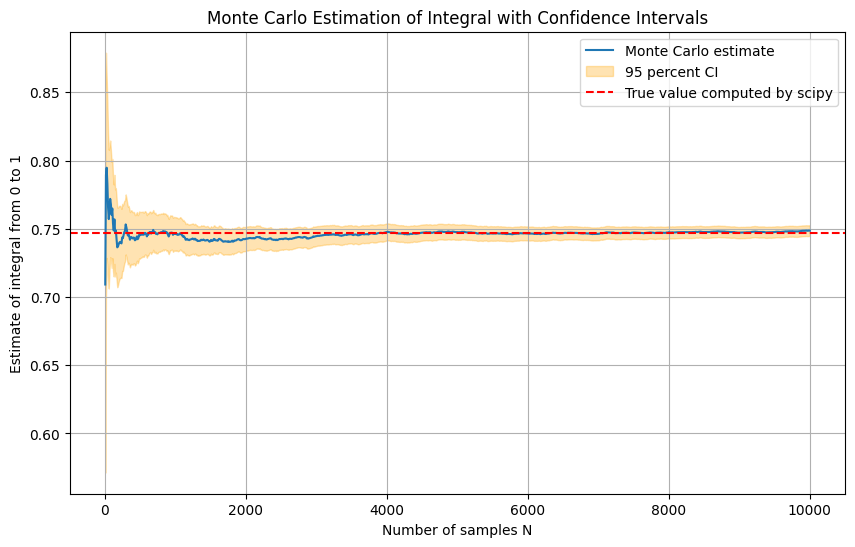

In [20]:
# Function to integrate
def f(x):
    return np.exp(-(x**2))


# Compute true integral using scipy
true_integral, _ = quad(f, 0, 1)

# Total number of samples
N_total = 10000
sample_sizes = np.arange(10, N_total + 1, 10)

# Generate uniform samples in range 0 to 1
x_samples = np.random.uniform(0, 1, N_total)
f_samples = f(x_samples)

# Monte Carlo estimates and confidence intervals
estimates = []
ci_lower = []
ci_upper = []

for N in sample_sizes:
    sample = f_samples[:N]
    mean_est = np.mean(sample)
    estimates.append(mean_est)

    # Sample standard deviation
    sigma_hat = np.std(sample, ddof=1)
    se = sigma_hat / np.sqrt(N)

    # 95 percent confidence interval
    ci_lower.append(mean_est - 1.96 * se)
    ci_upper.append(mean_est + 1.96 * se)

estimates = np.array(estimates)
ci_lower = np.array(ci_lower)
ci_upper = np.array(ci_upper)

# Plot convergence
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, estimates, label="Monte Carlo estimate")
plt.fill_between(
    sample_sizes, ci_lower, ci_upper, color="orange", alpha=0.3, label="95 percent CI"
)
plt.axhline(
    true_integral, color="red", linestyle="--", label="True value computed by scipy"
)
plt.xlabel("Number of samples N")
plt.ylabel("Estimate of integral from 0 to 1")
plt.title("Monte Carlo Estimation of Integral with Confidence Intervals")
plt.legend()
plt.grid(True)
plt.show()